(array([-0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
         1.75]),
 [Text(0, -0.5, '−0.50'),
  Text(0, -0.25, '−0.25'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.75, '0.75'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.25, '1.25'),
  Text(0, 1.5, '1.50'),
  Text(0, 1.75, '1.75')])

<Figure size 1200x800 with 0 Axes>

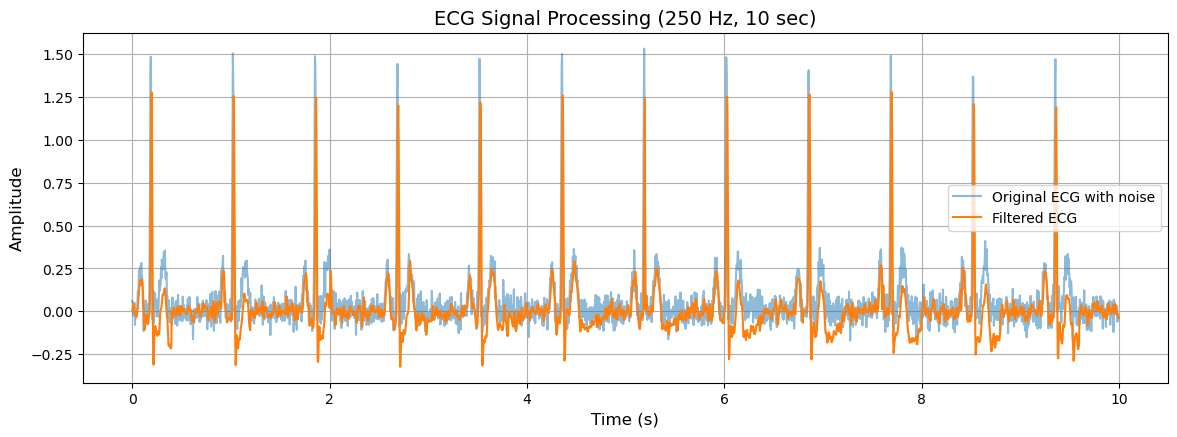

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks

fs = 250  
duration = 10 
block_size = 100
t = np.arange(0, duration, 1/fs)

def generate_ecg(t):

    hr = 72  
    rr_interval = 60/hr  
    
    ecg = np.zeros_like(t)
    for i in range(int(duration * hr / 60)):
        pos = i * rr_interval
        idx = np.where((t >= pos) & (t < pos + rr_interval))[0]
        if len(idx) == 0:
            continue
        
        # P wave
        p_start = pos + 0.05 * rr_interval
        p_end = pos + 0.15 * rr_interval
        p_idx = np.where((t >= p_start) & (t < p_end))[0]
        ecg[p_idx] += 0.25 * np.sin(np.pi * (t[p_idx] - p_start) / (p_end - p_start))**2
        
        # QRS complex
        qrs_start = pos + 0.2 * rr_interval
        qrs_end = pos + 0.25 * rr_interval
        qrs_idx = np.where((t >= qrs_start) & (t < qrs_end))[0]
        ecg[qrs_idx] += 1.5 * np.sin(np.pi * (t[qrs_idx] - qrs_start) / (qrs_end - qrs_start))**4
        
        # T wave
        t_start = pos + 0.3 * rr_interval
        t_end = pos + 0.45 * rr_interval
        t_idx = np.where((t >= t_start) & (t < t_end))[0]
        ecg[t_idx] += 0.3 * np.sin(np.pi * (t[t_idx] - t_start) / (t_end - t_start))**2
    
    noise = 0.05 * np.random.randn(len(t))
    return ecg + noise

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def process_ecg_blocks(ecg, block_size):
    num_blocks = len(ecg) // block_size
    filtered_ecg = np.zeros_like(ecg)
    heart_rates = []
    
    for i in range(num_blocks):
        start_idx = i * block_size
        end_idx = (i + 1) * block_size
        block = ecg[start_idx:end_idx]
        
        filtered_block = butter_bandpass_filter(block, 0.5, 40, fs, order=3)
        filtered_ecg[start_idx:end_idx] = filtered_block
        
        peaks, _ = find_peaks(filtered_block, height=0.5, distance=0.2*fs)
        
        if len(peaks) >= 2:
            rr_intervals = np.diff(peaks) / fs
            avg_rr = np.mean(rr_intervals)
            hr = 60 / avg_rr
            heart_rates.append(hr)
        else:
            heart_rates.append(np.nan)
    
    return filtered_ecg, heart_rates

ecg = generate_ecg(t)
filtered_ecg, heart_rates = process_ecg_blocks(ecg, block_size)

plt.figure(figsize=(12, 8))

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(t, ecg, label='Original ECG with noise', alpha=0.5)
plt.plot(t, filtered_ecg, label='Filtered ECG', linewidth=1.5)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.title('ECG Signal Processing (250 Hz, 10 sec)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)



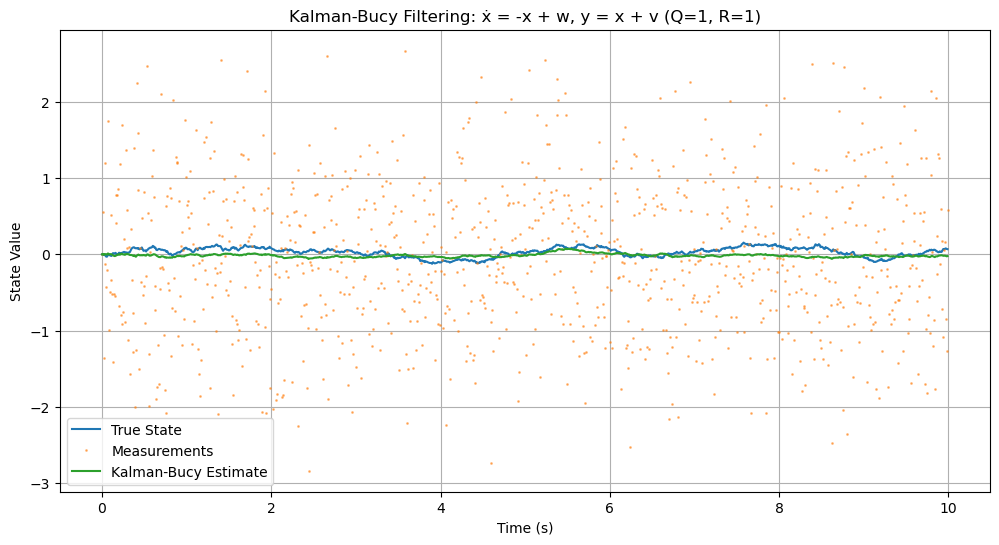

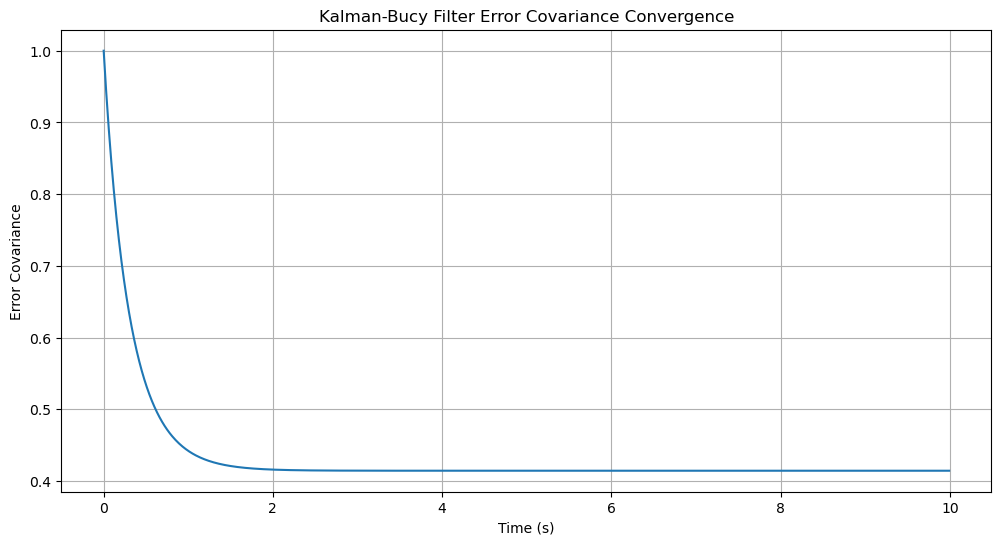

In [3]:
import numpy as np
import matplotlib.pyplot as plt

dt = 0.01  
T = 10 
steps = int(T / dt) 

A = -1 
C = 1  
Q = 1 
R = 1  

x_true = np.zeros(steps)
x_est = np.zeros(steps)
P = np.zeros(steps)  
y = np.zeros(steps)

x_true[0] = 0  
x_est[0] = 0  
P[0] = 1  

for k in range(1, steps):
    # True system dynamics with process noise
    x_true[k] = x_true[k-1] + (A * x_true[k-1] + np.sqrt(Q) * np.random.randn()) * dt
    
    # Measurement with noise
    y[k] = C * x_true[k] + np.sqrt(R) * np.random.randn()
    
    # Kalman-Bucy filter equations (continuous time)
    dx_est = A * x_est[k-1]
    dP = 2 * A * P[k-1] + Q - (C**2) * P[k-1]**2 / R
    
    # Measurement update (correction)
    K = P[k-1] * C / R  # Kalman gain
    
    # Euler integration
    x_est[k] = x_est[k-1] + (dx_est + K * (y[k] - C * x_est[k-1])) * dt
    P[k] = P[k-1] + dP * dt

t = np.arange(0, T, dt)
plt.figure(figsize=(12, 6))

plt.plot(t, x_true, label='True State', linewidth=1.5)
plt.plot(t, y, '.', markersize=2, label='Measurements', alpha=0.5)
plt.plot(t, x_est, label='Kalman-Bucy Estimate', linewidth=1.5)
plt.xlabel('Time (s)')
plt.ylabel('State Value')
plt.title('Kalman-Bucy Filtering: ẋ = -x + w, y = x + v (Q=1, R=1)')
plt.legend()
plt.grid(True)

plt.figure(figsize=(12, 6))
plt.plot(t, P, label='Estimation Error Covariance P(t)')
plt.xlabel('Time (s)')
plt.ylabel('Error Covariance')
plt.title('Kalman-Bucy Filter Error Covariance Convergence')
plt.grid(True)

plt.show()